In [21]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [22]:
train_csv_path=r'./Human Action Recognition/Training_set.csv'
test_csv_path=r'./Human Action Recognition/Testing_set.csv'
train_img_path=r'./Human Action Recognition/train'
test_img_path=r'./Human Action Recognition/test'
df=pd.read_csv(train_csv_path)

# modify df to have column names filepaths and labels
df.columns=['filepaths', 'labels']

# modify df so entries in filepaths column are the full path to the image file
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(train_img_path, x))

# split df into a train_df , a valid_df and a test_df
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])     
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  11340   test_df length:  630   valid_df length:  630
The number of classes in the dataset is:  15
            CLASS               IMAGE COUNT 
           calling                  756     
           clapping                 756     
           cycling                  756     
           dancing                  756     
           drinking                 756     
            eating                  756     
           fighting                 756     
           hugging                  756     
           laughing                 756     
      listening_to_music            756     
           running                  756     
           sitting                  756     
           sleeping                 756     
           texting                  756     
         using_laptop               756     
calling  has the most images=  756   calling  has the least images=  756
average height=  198  average width=  258 aspect ratio=  0.7662875270813989


<Axes: >

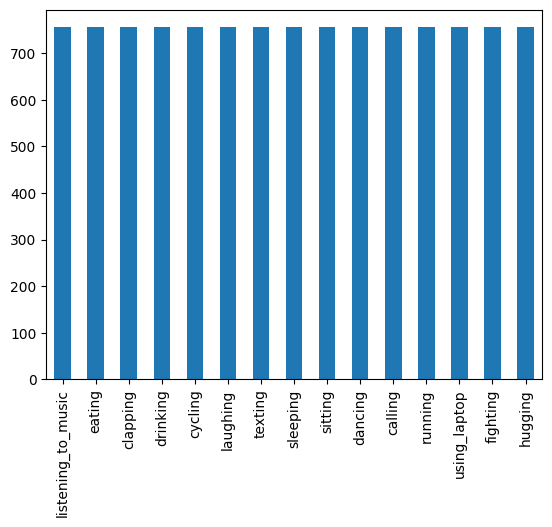

In [41]:
train_df['labels'].value_counts().plot.bar()

In [23]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=300 # since each class has more than 300 images all classes will be trimmed to have 300 images per class
min_samples=300
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300


In [24]:
working_dir=r'./'
img_size=(64,64)
batch_size=30
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 4500 validated image filenames belonging to 15 classes.          for train generator 
Found 630 validated image filenames belonging to 15 classes.           for valid generator 
Found 630 validated image filenames belonging to 15 classes.           for test generator 
test batch size:  70   test steps:  9  number of classes :  15


In [30]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.inception_v3 import InceptionV3
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.models import Sequential
#from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
#from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam as Bat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

import os  # Operating system functionality
import random  # Random number generator
import pandas as pd  # Data analysis & manipulation
import numpy as np  # Array-processing
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Data visualization
from tensorflow.keras import preprocessing, layers, models, callbacks  # Neural networks
from sklearn import metrics  # Model evaluation
from tensorflow.keras.utils import load_img,img_to_array

In [54]:
model1 = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
#model1.add(VGG16(input_shape=(224,224,3),pooling='avg',classes=1000,weights=vgg16_weights_path))
#resnet-50 , 87% accuracy with 100 epochs
model1.add(ResNet50(include_top=False,input_tensor=None,input_shape=(64,64,3),pooling='avg',classes=2,weights="imagenet"))
model1.add(Flatten())

model1.add(Dropout(0.5))
model1.add(BatchNormalization())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(BatchNormalization())
model1.add(Dense(15, activation='sigmoid'))

# model1.layers[0].trainable = False
model1.summary()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 batch_normalization_18 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                      

In [55]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
model_checkpoint_1 = ModelCheckpoint(filepath='./resnet.h5', monitor='loss',save_best_only=True)
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 10, mode='min', verbose=1, restore_best_weights=True)

cb_1 = [model_checkpoint_1,early_stopping_callback]



In [56]:
history_1 = model1.fit(train_gen,validation_data=valid_gen,epochs=200,shuffle=True,callbacks=cb_1)

Epoch 1/200
150/150 [==============================] - 40s 205ms/step - loss: 3.1396 - accuracy: 0.1011 - val_loss: 6696.3887 - val_accuracy: 0.0683
Epoch 2/200
150/150 [==============================] - 27s 177ms/step - loss: 2.9815 - accuracy: 0.1018 - val_loss: 2.6791 - val_accuracy: 0.1349
Epoch 3/200
150/150 [==============================] - 27s 179ms/step - loss: 2.8287 - accuracy: 0.1162 - val_loss: 2.6224 - val_accuracy: 0.1603
Epoch 4/200
150/150 [==============================] - 27s 182ms/step - loss: 2.7562 - accuracy: 0.1127 - val_loss: 4.9513 - val_accuracy: 0.1143
Epoch 5/200
150/150 [==============================] - 27s 178ms/step - loss: 2.6813 - accuracy: 0.1213 - val_loss: 4.5604 - val_accuracy: 0.0984
Epoch 6/200
150/150 [==============================] - 27s 178ms/step - loss: 2.6283 - accuracy: 0.1442 - val_loss: 3.0060 - val_accuracy: 0.1810
Epoch 7/200
150/150 [==============================] - 27s 180ms/step - loss: 2.5904 - accuracy: 0.1456 - val_loss: 2.476

In [18]:
from keras.models import load_model
m_1 = load_model("./resnet.h5")

In [6]:
model_checkpoint_2 = ModelCheckpoint(filepath='./vgg.h5', monitor='loss',save_best_only=True)
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 10, mode='min', verbose=1, restore_best_weights=True)

cb_2 = [model_checkpoint_2,early_stopping_callback]


In [7]:
model2 = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
model2.add(VGG16(include_top=False,input_shape=(64,64,3),pooling='avg',classes=1000,weights="imagenet"))
#resnet-50 , 87% accuracy with 100 epochs
#model2.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2,weights="imagenet"))
model2.add(Flatten())

model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(15, activation='sigmoid'))

# model2.layers[0].trainable = False
model2.summary()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [8]:
history_2 = model2.fit(train_gen,validation_data=valid_gen,epochs=240,shuffle=True,callbacks=cb_2)

Epoch 1/240
150/150 [==============================] - 29s 163ms/step - loss: 3.2997 - accuracy: 0.0696 - val_loss: 12.8164 - val_accuracy: 0.0984
Epoch 2/240
150/150 [==============================] - 22s 145ms/step - loss: 2.9814 - accuracy: 0.0862 - val_loss: 84.7939 - val_accuracy: 0.1143
Epoch 3/240
150/150 [==============================] - 22s 147ms/step - loss: 2.8392 - accuracy: 0.0987 - val_loss: 3.4949 - val_accuracy: 0.0937
Epoch 4/240
150/150 [==============================] - 22s 147ms/step - loss: 2.7503 - accuracy: 0.1047 - val_loss: 37554.2188 - val_accuracy: 0.0937
Epoch 5/240
150/150 [==============================] - 22s 147ms/step - loss: 2.7053 - accuracy: 0.1056 - val_loss: 3.2701 - val_accuracy: 0.0905
Epoch 6/240
150/150 [==============================] - 23s 150ms/step - loss: 2.6419 - accuracy: 0.1169 - val_loss: 2.7631 - val_accuracy: 0.1270
Epoch 7/240
150/150 [==============================] - 22s 148ms/step - loss: 2.6110 - accuracy: 0.1220 - val_loss: 2.

In [19]:
m_2 = load_model("./vgg.h5")

In [88]:
train_gen.class_indices

{'calling': 0,
 'clapping': 1,
 'cycling': 2,
 'dancing': 3,
 'drinking': 4,
 'eating': 5,
 'fighting': 6,
 'hugging': 7,
 'laughing': 8,
 'listening_to_music': 9,
 'running': 10,
 'sitting': 11,
 'sleeping': 12,
 'texting': 13,
 'using_laptop': 14}

Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


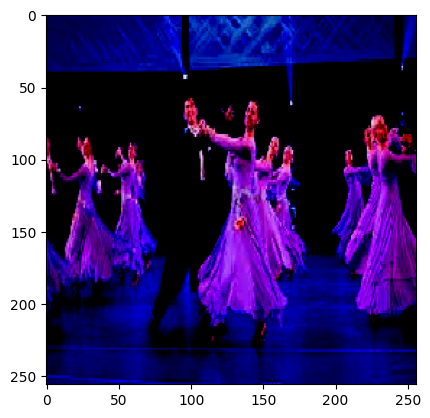

1/1 [==============================] - 0s 37ms/step
3 {'dancing'}


In [148]:
img_path = "G:\Machine_Learning_Github\human-activity-rec\Human Action Recognition\\test\Image_72.jpg"
test_image = load_img(img_path, target_size=(256,256))
input = img_to_array(test_image)
input = preprocess_input(input)
input_arr = np.array(input)
plt.imshow(input_arr)
plt.show()
input_arr = np.expand_dims(input_arr,axis=0)
pred_class=np.argmax(m_1.predict(input_arr))
action = {i for i in train_gen.class_indices if train_gen.class_indices[i]==pred_class} 
print(pred_class,action)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


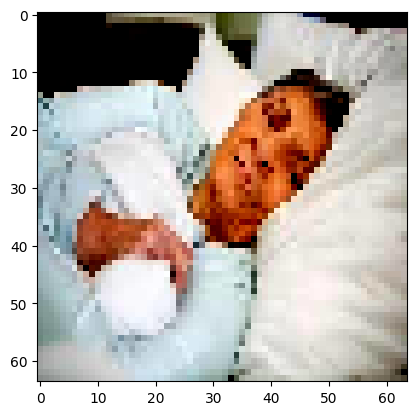

1/1 [==============================] - 0s 29ms/step
12 {'sleeping'}


In [41]:
img_path = "G:\Machine_Learning_Github\human-activity-rec\Human Action Recognition\\test\Image_410.jpg"
test_image = load_img(img_path, target_size=(64,64))
input = img_to_array(test_image)
input = preprocess_input(input)
input_arr = np.array(input)
plt.imshow(input_arr)
plt.show()
input_arr = np.expand_dims(input_arr,axis=0)
pred_class=np.argmax(m_2.predict(input_arr))
action = {i for i in train_gen.class_indices if train_gen.class_indices[i]==pred_class} 
print(pred_class,action)

In [ ]:
model3 = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
model3.add(InceptionV3(include_top=False,input_shape=(64,64,3),pooling='avg',classes=1000,weights="imagenet"))
model3.add(Flatten())

model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(15, activation='sigmoid'))

# model3.layers[0].trainable = False
model3.summary()
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
history_3 = model3.fit(train_gen,validation_data=valid_gen,epochs=25,shuffle=True)

Epoch 1/25
150/150 [==============================] - 23s 155ms/step - loss: 0.4388 - accuracy: 0.8660 - val_loss: 2.7558 - val_accuracy: 0.4222
Epoch 2/25
150/150 [==============================] - 21s 140ms/step - loss: 0.4530 - accuracy: 0.8567 - val_loss: 2.9088 - val_accuracy: 0.4079
Epoch 3/25
150/150 [==============================] - 20s 131ms/step - loss: 0.4324 - accuracy: 0.8680 - val_loss: 2.7441 - val_accuracy: 0.4365
Epoch 4/25
150/150 [==============================] - 22s 143ms/step - loss: 0.4097 - accuracy: 0.8780 - val_loss: 2091703.2500 - val_accuracy: 0.4016
Epoch 5/25
150/150 [==============================] - 22s 147ms/step - loss: 0.4962 - accuracy: 0.8462 - val_loss: 3.2160 - val_accuracy: 0.3635
Epoch 6/25
150/150 [==============================] - 21s 141ms/step - loss: 0.4420 - accuracy: 0.8642 - val_loss: 2.7413 - val_accuracy: 0.4317
Epoch 7/25
150/150 [==============================] - 23s 151ms/step - loss: 0.4180 - accuracy: 0.8660 - val_loss: 2.8366 - 

In [61]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
plt.plot(history_1.history['accuracy'],c="green")
plt.plot(history_1.history['loss'],c="red")
plt.title("Model Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

NameError: name 'history_1' is not defined

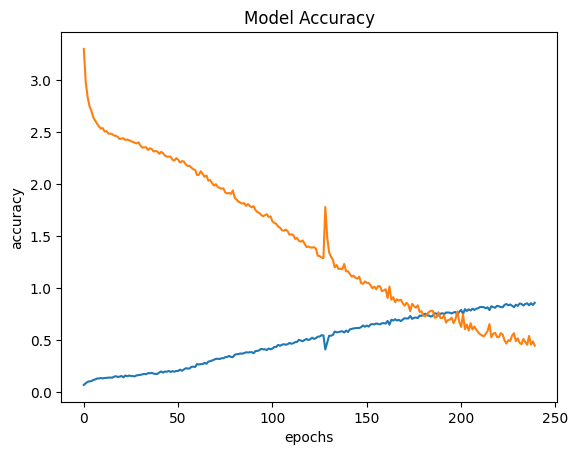

In [9]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['loss'])
plt.title("Model Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()